In [35]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [36]:
path = "./trabajo4.csv"
df = pd.read_csv(path)

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
df_per = df.groupby(['hotel', ])["adults", "children", "babies"].mean()

C:\Users\hugue\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='hotel'>

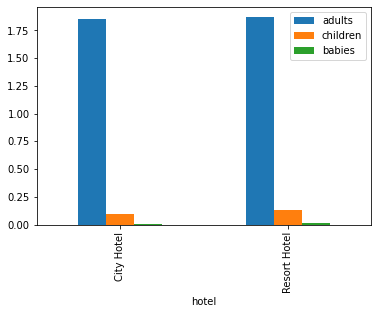

In [39]:
df_per.plot.bar()

We can see here that the number of childrens and babies is almost null.
Only the number of adults is significant.

In [40]:
df_country = df["country"].value_counts(normalize=True)

C:\Users\hugue\AppData\Local\Python\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='country'>

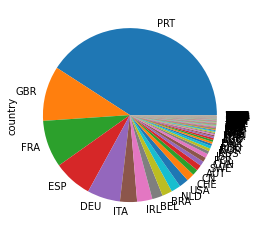

In [41]:
df_country.plot.pie()

Most people come from Portugal

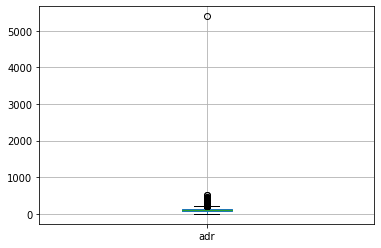

In [42]:
boxplot = df.boxplot(column=['adr'])

In [43]:
df["adr"].max()

5400.0

In [44]:
df = df.drop(df[df['adr'] == 5400.0].index)

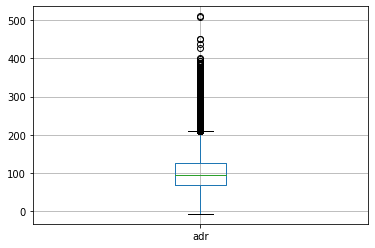

In [45]:
boxplot = df.boxplot(column=['adr'])

In [46]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [47]:
df['arrival_date_month'].loc[(df['arrival_date_month'] == "January")] = 1
df['arrival_date_month'].loc[(df['arrival_date_month'] == "February")] = 2
df['arrival_date_month'].loc[(df['arrival_date_month'] == "March")] = 3
df['arrival_date_month'].loc[(df['arrival_date_month'] == "April")] = 4
df['arrival_date_month'].loc[(df['arrival_date_month'] == "May")] = 5
df['arrival_date_month'].loc[(df['arrival_date_month'] == "June")] = 6
df['arrival_date_month'].loc[(df['arrival_date_month'] == "July")] = 7
df['arrival_date_month'].loc[(df['arrival_date_month'] == "August")] = 8
df['arrival_date_month'].loc[(df['arrival_date_month'] == "September")] = 9
df['arrival_date_month'].loc[(df['arrival_date_month'] == "October")] = 10
df['arrival_date_month'].loc[(df['arrival_date_month'] == "November")] = 11
df['arrival_date_month'].loc[(df['arrival_date_month'] == "December")] = 12
arrival_date = pd.to_datetime(df.arrival_date_year*10000+df.arrival_date_month*100+df.arrival_date_day_of_month,format='%Y%m%d')
df["arrival_date"] = arrival_date

C:\Users\hugue\AppData\Local\Python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
df = df.drop(["arrival_date_year","arrival_date_month","arrival_date_week_number","arrival_date_day_of_month","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","agent","company","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests","lead_time","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type","reservation_status_date"],1)


In [49]:
df["room_occupied"] = 1

In [50]:
df.head()

,hotel,is_canceled,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,adr,reservation_status,arrival_date,room_occupied
0,Resort Hotel,0,0,0,2,0.0,0,0.0,Check-Out,2015-07-01,1
1,Resort Hotel,0,0,0,2,0.0,0,0.0,Check-Out,2015-07-01,1
2,Resort Hotel,0,0,1,1,0.0,0,75.0,Check-Out,2015-07-01,1
3,Resort Hotel,0,0,1,1,0.0,0,75.0,Check-Out,2015-07-01,1
4,Resort Hotel,0,0,2,2,0.0,0,98.0,Check-Out,2015-07-01,1


In [51]:
def agrupacion_diaria(df,col,hotel):
    """
    Esta funcion la utilizaremos para crear la serie temporal que toma el beneficio diario basado en ADR
    
    Parametros:
        df: pd.DataFrame
            Dataframe que contiene los datos de los hoteles
        col: str
            Nombre de la columna que va a ser agrupada
        hotel:
            Nombre del hotel que se decide hacer la agrupación para estudiar sus beneficios
    
    Resultado:
        grouped: pd.DataFrame
            Serie temporal que agrupa la columna anterior
    
    """
    # Paso 0: Estructura general a la que iremos añadiendo los valores
    df_hotel = df[df["hotel"] == hotel]
    
    
    # Si estamos midiendo el ADR quitamos los que no reportan beneficio
    if col == "adr":
        df_hotel = df_hotel[df_hotel["adr"] != 0]
    
    # Numero de noches que han reservado e intervalo entre inicio y final de estancia
    
    df_hotel["total_nights"] = df_hotel["stays_in_weekend_nights"] + df_hotel["stays_in_week_nights"]

    print("Estableciendo el intervalo de las noches que han pasado los clientes del hotel {}".format(hotel))
    df_hotel["check_out_day"] = df_hotel.apply(lambda row: row["arrival_date"] + timedelta(days = row["total_nights"]), axis = 1)
    
    # Seleccionamos la primera fecha de entrada y la última fecha de salida
    min_date = df_hotel["arrival_date"].min()
    max_date = df_hotel["check_out_day"].max() - timedelta(days = 1)
    full_range = pd.date_range(min_date, max_date, freq = "D")
    
    # Creamos una estructura a detalle diario que vaya desde la fecha mínima a la fecha máxima
    grouped = pd.DataFrame()
    
    grouped["date"] = full_range
    
    # Creamos una columna auxiliar llena de ceros a la que iremos sumando la agrupacion por columna
    grouped[col] = 0

    # Paso 1: caso general, los clientes se hospedan con normalidad (reservation_status == "Check-Out")
    
    check_out = df_hotel[df_hotel["reservation_status"] == "Check-Out"]
    check_out = check_out[["arrival_date","total_nights",col, "check_out_day"]]
    

    # Calculamos el beneficio en cada una de las noches del hotel basandonos en el ADR 
    print("Agrupando los resultados por noche de la variable {} para los clientes que realizaron Check-Out en el {}".format(col,hotel))
    for date in full_range:
        date_df = check_out[(check_out["arrival_date"] <= date) & (check_out["check_out_day"] > date)]
        suma = date_df[col].sum()
        grouped.loc[grouped["date"] == date, col] = suma
        del date_df
    print("Agrupacion completada de la variable {} para clientes que realizaron Check-Out en el {}".format(col,hotel))
    print(" ")
    
    del check_out
    
    # En caso de que estuvieramos estudiando el adr podemos añadir los beneficios por cancelaciones o no apariciones 
    
    if col == "adr":
        # Paso 2: cancelaciones, el beneficio que generen los clientes que cancelan su reserva se aplicarán
        # a los teóricos días de estancia, como en el caso anterior
        grouped[col + "_canceled"] = 0
        print("Agrupando los resultados por noche de la variable {} para aquellos clientes que cancelaron su reserva en el {}".format(col,hotel))
        cancel = df_hotel[df_hotel["reservation_status"] == "Canceled"]
        cancel = cancel[["arrival_date","total_nights",col, "check_out_day"]]
        
        for date in full_range:
            date_df = cancel[(cancel["arrival_date"] <= date) & (cancel["check_out_day"] > date)]
            suma = date_df[col].sum()
            grouped.loc[grouped["date"] == date, col + "_canceled"] += suma
            del date_df
        print("Agrupacion completada de la variable {} para clientes que cancelaron su reserva en el {}".format(col, hotel))
        print(" ")
       
        # Paso 3: el cliente no aparece el dia reservado, el beneficio generado por estos clientes se aplica al dia de entrada
        grouped[col + "_noshow"] = 0
        print("Agrupando los resultados por noche de la variable {} para aquellos clientes que no acudieron a su reserva en el {}".format(col, hotel))
        no_show = df_hotel[df_hotel["reservation_status"] == "No-Show"]
        no_show = no_show[["arrival_date","total_nights",col, "check_out_day"]]
        
        for date in full_range:
            date_df = no_show[(no_show["arrival_date"] <= date) & (no_show["check_out_day"] > date)]
            suma = date_df[col].sum()
            grouped.loc[grouped["date"] == date, col + "_noshow"] += suma
            del date_df
        print("Agrupacion completada de la variable {} para clientes que no acudieron a su reserva en el {}".format(col, hotel))
        print(" ")
        
    grouped.set_index("date",inplace = True)
    return grouped

In [52]:
df_city = agrupacion_diaria(df, "adr", "City Hotel")

Estableciendo el intervalo de las noches que han pasado los clientes del hotel City Hotel
Agrupando los resultados por noche de la variable adr para los clientes que realizaron Check-Out en el City Hotel
Agrupacion completada de la variable adr para clientes que realizaron Check-Out en el City Hotel
 
Agrupando los resultados por noche de la variable adr para aquellos clientes que cancelaron su reserva en el City Hotel
Agrupacion completada de la variable adr para clientes que cancelaron su reserva en el City Hotel
 
Agrupando los resultados por noche de la variable adr para aquellos clientes que no acudieron a su reserva en el City Hotel
Agrupacion completada de la variable adr para clientes que no acudieron a su reserva en el City Hotel
 


In [53]:
df_city[(df_city.index > datetime(2015,7,10)) & (df_city.index < datetime(2017,8,31))]

,adr,adr_canceled,adr_noshow
date,,,
2015-07-11,3153.20,4005.44,68.00
2015-07-12,2870.28,5243.09,68.00
2015-07-13,2790.03,6559.59,638.64
2015-07-14,168.62,3989.76,144.50
2015-07-15,1452.37,2164.41,233.75
...,...,...,...
2017-08-26,29465.21,16653.35,0.00
2017-08-27,25165.48,15235.53,370.50
2017-08-28,26796.17,13055.43,244.25


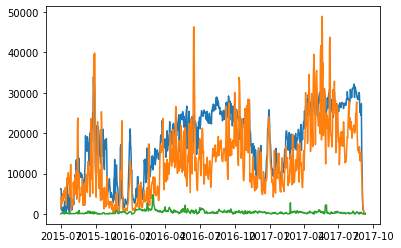

In [54]:
plt.plot(df_city)

Set profile clients in hotel

How can I do the forecast ?